<div class="alert alert-block alert-info">
<p style="font-size:24px;text-align:center"><b>Propagate a low-resolution hand-crafted laser pulse through a thin lens.</b>
<br>We initialize the laser pulse from the <b>Pump Off</b> experimental configuration.
</div>

In [1]:
import array
import math
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
import os

from pykern.pkcollections import PKDict
# The rslaser library may not be installed, so a check is required.
try:
    import rslaser
except:
    print("The rslaser library was not found; installing from GitHub...")
    # Developers should use 'pip install -e .' from the command line.
    # Users can install directly from GitHub --
    !{sys.executable} -m pip install git+https://github.com/radiasoft/rslaser.git
    import rslaser
from rslaser.optics import wavefront
from rslaser.optics import crystal
from rslaser.utils import merit_functions
from rslaser.pulse import pulse
from rslaser.optics import drift
from rslaser.optics import lens

import scipy
from scipy import constants, ndimage, stats
from scipy.ndimage.filters import gaussian_filter

In [2]:
"""CalcIntFromElecField(_arI, _inWfr, _inPol, _inIntType, _inDepType, _inE, _inX, _inY)
function calculates/"extracts" Intensity from pre-calculated Electric Field
:param _arI: output resulting Intensity array (should be allocated in Python script before calling this function)
:param _inWfr: input pre-calculated Wavefront structure (instance of SRWLWfr)
:param _inPol: input switch specifying polarization component to be extracted:
               =0 -Linear Horizontal; 
               =1 -Linear Vertical; 
               =2 -Linear 45 degrees; 
               =3 -Linear 135 degrees;
               =4 -Circular Right; 
               =5 -Circular Left; 
               =6 -Total
:param _inIntType: input switch specifying "type" of a characteristic to be extracted:
               =0 -"Single-Electron" Intensity; 
               =1 -"Multi-Electron" Intensity; 
               =2 -"Single-Electron" Flux; 
               =3 -"Multi-Electron" Flux; 
               =4 -"Single-Electron" Radiation Phase; NOTE: requires DOUBLE PRECISION array via srwlib.array('d', ...)
               =5 -Re(E): Real part of Single-Electron Electric Field;
               =6 -Im(E): Imaginary part of Single-Electron Electric Field;
               =7 -"Single-Electron" Intensity, integrated over Time or Photon Energy (i.e. Fluence)
               =8 -"Single-Electron" Mutual Intensity (i.e. E(r)E*(r')) 
:param _inDepType: input switch specifying type of dependence to be extracted:
               =0 -vs e (photon energy or time);
               =1 -vs x (horizontal position or angle);
               =2 -vs y (vertical position or angle);
               =3 -vs x&y (horizontal and vertical positions or angles);
               =4 -vs e&x (photon energy or time and horizontal position or angle);
               =5 -vs e&y (photon energy or time and vertical position or angle);
               =6 -vs e&x&y (photon energy or time, horizontal and vertical positions or angles);
:param _inE: input photon energy [eV] or time [s] to keep fixed (to be taken into account for dependences vs x, y, x&y)
:param _inX: input horizontal position [m] to keep fixed (to be taken into account for dependences vs e, y, e&y)
:param _inY: input vertical position [m] to keep fixed (to be taken into account for dependences vs e, x, e&x)
"""
import srwlib
from srwlib import srwl

In [3]:
# 2D plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

# reset the notebook style
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline

# Specify whether 2D and/or 3D plots should be rendered
RENDER_2D_PLOTS = True
PLOT_DATA = False
RENDER_3D_PLOTS = False

# 3D plotting
if RENDER_3D_PLOTS:
    import plotly.graph_objects as go

In [4]:
# Let's read an image-pair of diagnostic data files to instantiate an SRW wavefront.
# First, we have to determine the file paths...
ccd_name = 'ccd_pump_off.txt'
wfs_name = 'wfs_pump_off.txt'

package_data_dir = rslaser.pkg_resources.resource_filename('rslaser','package_data')
ccd_path_to_file = os.path.join(package_data_dir, ccd_name)
wfs_path_to_file = os.path.join(package_data_dir, wfs_name)

# read the pixel size from the diagnostic metadata file
meta_file_name = 'wfs_meta.dat'
meta_path_to_file = os.path.join(package_data_dir, meta_file_name)
with open(meta_path_to_file) as fh:
    for line in fh:
        if line.startswith("pixel_size_h_microns"):
            pixel_size_h = float(line.split(":")[-1].split(",")[0])  # microns
        if line.startswith("pixel_size_v_microns"):
            pixel_size_v = float(line.split(":")[-1].split(",")[0])  # microns

# central wavelength of the laser pulse
lambda0_micron = 0.8

In [5]:
def rms_calc_2d(_x, _y, f_dist):
    """
    Calculate the x and y averages and RMS of a 2d distribution f_dist(x,y)

    Args:
        _x, 2d numpy array that defines x values of the distribution
        _y, 2d numpy array that defines y values of the distribution
        f_dist, 2d numpy array that defines the x,y distribution
    
    Returns:
        x_avg, y_avg, the average values of x and y
        x_rms, y_rms, the RMS values of x and y

    Example:
        >>> xavg, yavg, xrms, yrms = rms_calc_2d(my_array)
    """
    x_f = np.multiply(_x, f_dist)
    y_f = np.multiply(_y, f_dist)
    sum_f = np.sum(f_dist)
    x_avg = np.sum(x_f) / sum_f
    y_avg = np.sum(y_f) / sum_f

    xsq_f = np.multiply(_x, x_f)
    ysq_f = np.multiply(_y, y_f)
    x_std = np.sum(xsq_f) / sum_f
    y_std = np.sum(ysq_f) / sum_f

    x_rms = math.sqrt(x_std - x_avg**2)
    y_rms = math.sqrt(y_std - y_avg**2)
    return x_avg, y_avg, x_rms, y_rms

In [6]:
def nan_helper(_arr):
    """
    Clean unwanted NaNs from a numpy array, replacing them via interpolation.

    Args:
        _arr, numpy array with NaNs
    
    Returns:
        nans, logical indices of NaNs
        index, a function with signature indices = index(logical_indices)
               to convert logical indices of NaNs to 'equivalent' indices

    Example:
        >>> nans, x = nan_helper(my_array)
        >>> my_array[nans] = np.interp(x(nans), x(~nans), my_array[~nans])
    """
    return np.isnan(_arr), lambda z: z.nonzero()[0]

def array_cleaner(_arr, _ind):
    """
    Clean unwanted values from a numpy array, replacing them via interpolation.

    Args:
        _arr, numpy array with bad values
        _ind, precalculated indices of these bad values
    
    Returns:
        _arr, cleaned version of the input array

    Example:
        >>> indices = np.isnan(my_array)
        >>> my_array = array_cleaner(my_array, indices)
    """
    _arr[_ind] = np.nan
    nans, x = nan_helper(_arr)
    _arr[nans] = np.interp(x(nans), x(~nans), _arr[~nans])
    return _arr

In [7]:
# parse the intensity diagnostic data file
ccd_data = np.genfromtxt(ccd_path_to_file, skip_header=1)
print('ccd_data.shape = ', ccd_data.shape)

ccd_data = np.delete(ccd_data, 0, axis=1)
ccd_data = np.delete(ccd_data, 1, axis=1)
ccd_data = np.delete(ccd_data, 2, axis=1)
ccd_data = np.delete(ccd_data, 3, axis=1)
ccd_data = np.delete(ccd_data, -4, axis=1)
ccd_data = np.delete(ccd_data, -3, axis=1)
ccd_data = np.delete(ccd_data, -2, axis=1)
ccd_data = np.delete(ccd_data, -1, axis=1)
print('ccd_data.shape = ', ccd_data.shape)

ccd_data.shape =  (32, 40)
ccd_data.shape =  (32, 32)


In [8]:
# specify the mesh size
nx = ccd_data.shape[1]
ny = ccd_data.shape[0]

# create the x,y arrays with physical units based on the diagnostic pixel dimensions
x_max = 0.002    # [m]
x_min = -x_max
x1 = np.linspace(x_min, x_max, nx)

y_max = x_max
y_min = -y_max
y1 = np.linspace(y_min, y_max, ny)

x, y = np.meshgrid(x1, y1)

if False:
    print('x_min = ', np.min(x1))
    print('x_max = ', np.max(x1))
    print('x1.shape = ', x1.shape)

    print('y_min = ', np.min(y1))
    print('y_max = ', np.max(y1))
    print('y1.shape = ', y1.shape)
    
# Calculate intensity centroid and RMS values
xc, yc, xc_rms, yc_rms = rms_calc_2d(x, y, ccd_data)

In [9]:
# parse the measured phases of the wavefront
wfs_data = np.genfromtxt(wfs_path_to_file, skip_header=1, skip_footer=0)

# clean up any NaN's
indices = np.isnan(wfs_data)
wfs_data = array_cleaner(wfs_data, indices)

wfs_data = np.delete(wfs_data, 0, axis=1)
wfs_data = np.delete(wfs_data, 1, axis=1)
wfs_data = np.delete(wfs_data, 2, axis=1)
wfs_data = np.delete(wfs_data, 3, axis=1)
wfs_data = np.delete(wfs_data, -4, axis=1)
wfs_data = np.delete(wfs_data, -3, axis=1)
wfs_data = np.delete(wfs_data, -2, axis=1)
wfs_data = np.delete(wfs_data, -1, axis=1)

# convert from microns to radians
rad_per_micron = math.pi / lambda0_micron
wfs_data *= rad_per_micron

phi_min=np.min(wfs_data)
phi_max=np.max(wfs_data)

# we assume the WFS and CCD data are from the same diagnostic
# check that the data files have the same number of pixels
assert np.shape(wfs_data) == np.shape(ccd_data), error_message('ERROR -- WFS and CCD data have diferent shapes!!')

In [10]:
# Calulate the real and imaginary parts of the Ex,Ey electric field components
e_norm = np.sqrt(ccd_data)
ex_real = np.multiply(e_norm, np.cos(wfs_data)).flatten(order='C')
ex_imag = np.multiply(e_norm, np.sin(wfs_data)).flatten(order='C')

ex_numpy = np.zeros(2*len(ex_real))
for i in range(len(ex_real)):
    ex_numpy[2*i] = ex_real[i]
    ex_numpy[2*i+1] = ex_imag[i]

ex = array.array('f', ex_numpy.tolist())
ey = array.array('f', len(ex)*[0.])

In [11]:
wfr0 = srwlib.SRWLWfr(_arEx=ex, _arEy=ey, _typeE='f', 
                    _eStart=1.55, _eFin=1.55, _ne=1, 
                    _xStart=x_min, _xFin=x_max, _nx=nx, 
                    _yStart=y_min, _yFin=y_max, _ny=ny, 
                    _zStart=0., _partBeam=None)

In [12]:
#Plot measured intensity
if RENDER_2D_PLOTS and PLOT_DATA:
    with plt.style.context(('seaborn-poster')):
        fig = plt.figure(figsize=(12,7.2))
        ax = fig.gca()
        plt.pcolormesh(x*1e3, y*1e3, ccd_data, cmap=plt.cm.viridis, shading='auto')
        plt.colorbar()
        ax.set_ylabel(r'Vertical Position [mm]')
        ax.set_xlabel(r'Horizontal Position [mm]')
        ax.set_title('Intensity (measured)')

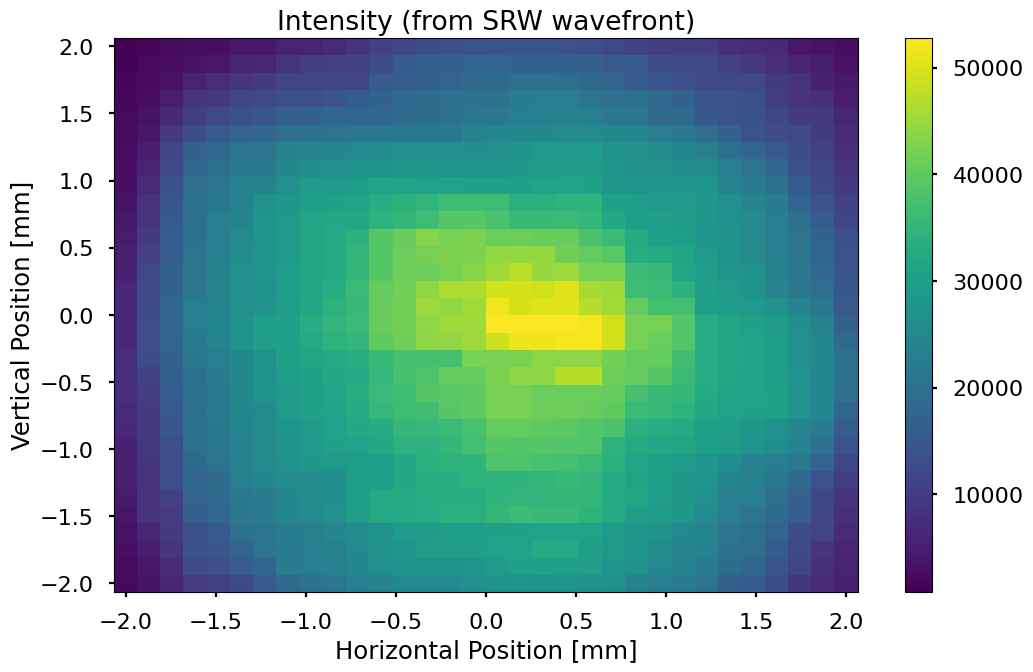

In [13]:
#Plot intensity from the SRW wavefront calculation
intens0 = srwlib.array('f', [0]*wfr0.mesh.nx*wfr0.mesh.ny) # "flat" array to take 2D intensity data
srwl.CalcIntFromElecField(intens0, wfr0, 6, 0, 3, wfr0.mesh.eStart, 0, 0) #extracts intensity

##Reshaping electric field data from flat to 2D array
intens0_2d = np.array(intens0).reshape((wfr0.mesh.nx, wfr0.mesh.ny), order='C')

if RENDER_2D_PLOTS:
    with plt.style.context(('seaborn-poster')):
        fig = plt.figure(figsize=(12,7.2))
        ax = fig.gca()
        plt.pcolormesh(x*1e3, y*1e3, intens0_2d, cmap=plt.cm.viridis, shading='auto')
        plt.colorbar()
        ax.set_ylabel(r'Vertical Position [mm]')
        ax.set_xlabel(r'Horizontal Position [mm]')
        ax.set_title('Intensity (from SRW wavefront)')

In [14]:
# plot the phase
if RENDER_2D_PLOTS and PLOT_DATA:
    with plt.style.context(('seaborn-poster')):
        fig = plt.figure(figsize=(12,7.2))
        ax = fig.gca()
        plt.pcolormesh(x*1e3, y*1e3, wfs_data, cmap=plt.cm.viridis, shading='auto')
        plt.colorbar()
        ax.set_xlabel(r'Horizontal Position [mm]')
        ax.set_ylabel(r'Vertical Position [mm]')
        ax.set_title('Phase (measured)')

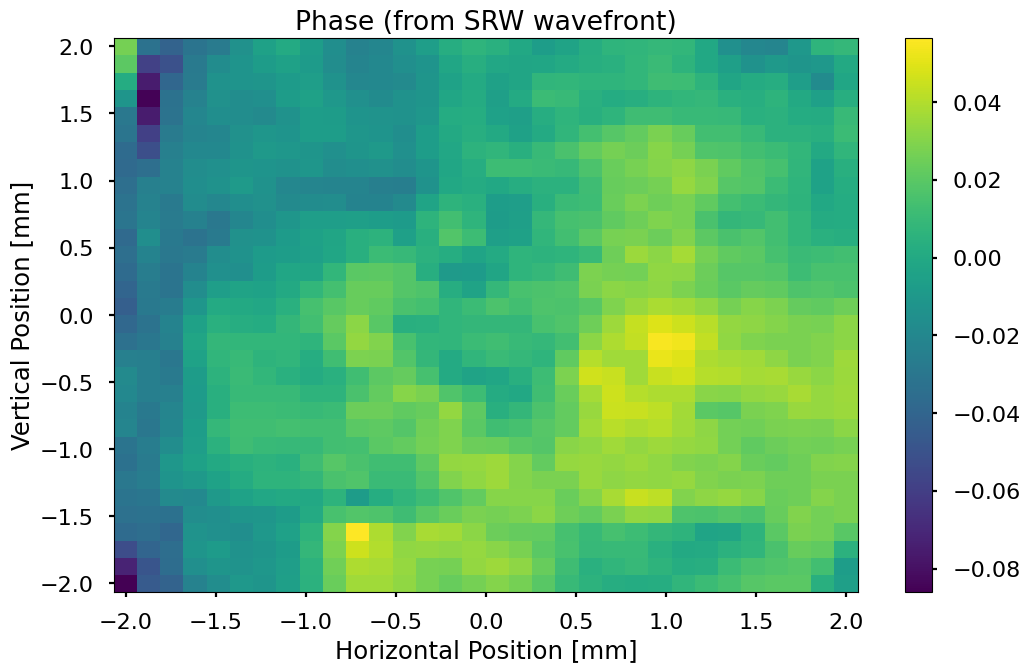

In [15]:
# initial phase
phase0 = srwlib.array('d', [0]*wfr0.mesh.nx*wfr0.mesh.ny) # "flat" array to take 2D intensity data
srwl.CalcIntFromElecField(phase0, wfr0, 0, 4, 3, wfr0.mesh.eStart, 0, 0) #extracts the phase; must use double precision

##Reshaping electric field data from flat to 2D array
phase0_2d = np.array(phase0).reshape((wfr0.mesh.nx, wfr0.mesh.ny), order='C')

# plot the phase
if RENDER_2D_PLOTS:
    with plt.style.context(('seaborn-poster')):
        fig = plt.figure(figsize=(12,7.2))
        ax = fig.gca()
        plt.pcolormesh(x*1e3, y*1e3, phase0_2d, cmap=plt.cm.viridis, shading='auto')
        plt.colorbar()
        ax.set_xlabel(r'Horizontal Position [mm]')
        ax.set_ylabel(r'Vertical Position [mm]')
        ax.set_title('Phase (from SRW wavefront)')

In [16]:
# calculate the wavefront centroid and rms properties
x_avg, y_avg, x_rms, y_rms = rms_calc_2d(x, y, intens0_2d)

print(' x_avg = {0:4.2e} [m]'.format(x_avg))
print(' y_avg = {0:4.2e} [m]'.format(y_avg))
print(' ')
print(' x_rms = {0:4.2e} [m]'.format(x_rms))
print(' y_rms = {0:4.2e} [m]'.format(y_rms))

 x_avg = 9.65e-05 [m]
 y_avg = -1.39e-04 [m]
 
 x_rms = 9.97e-04 [m]
 y_rms = 1.04e-03 [m]


In [17]:
# create a laser pulse, using the wavefront created above

# # photon energy corresponding to lambda = 1 micron
# _LASER_PULSE_SLICE = PKDict(
#     sigrW = math.sqrt(x_rms*y_rms),
#     propLen = 15,
#     pulseE = 0.001,
#     poltype = 1,
#     sampFact = 0.002,
#     mx = 0,
#     my = 0
# )
# _LASER_PULSE = PKDict(
#         phE = 1.55,
#         nslice = 1,
#         chirp = 0,
#         w0 = 2.*math.sqrt(x_rms*y_rms),
#         a0 = .002,
#         dw0x = 0.0,
#         dw0y = 0.0,
#         z_waist = -0.1,
#         dzwx = 0.0,
#         dzwy = 0.0,
#         tau_fwhm = 0.1 / constants.c / math.sqrt(2.),
#         z_center = 0.,
#         x_shift = 0.,
#         y_shift = 0.,
#         d_to_w = 0.1,
#         slice_params=_LASER_PULSE_SLICE,
# )

_LASER_PULSE = PKDict(
        nslice = 1,
        chirp = 0,
        photon_e_ev = 1.55,
        sigx_waist = x_rms,
        sigy_waist = y_rms,
)

In [18]:
# instantiate the laser pulse (this can take a few seconds)
in_pulse = PKDict(
    **_LASER_PULSE
    )
LP = pulse.LaserPulse(in_pulse)

slice=LP.slice
slice[0].wfr = wfr0

<div class="alert alert-block alert-info">
<p style="font-size:18px;">Propagate the laser pulse through a Ti:Sapphire crystal and 50 cm drift.</p>
</div>

In [19]:
# instantiate the crystal with laser pumping on
L_crystal = 0.01   # [m]
num_slices = 1

crystal_params = PKDict(
        n0 = [1.76 for _ in range(num_slices)],
        n2 = [4.0  for _ in range(num_slices)],
        length = L_crystal,
        nslice = num_slices,
#        l_scale = 0.001,    # uncomment when using LCT-based propagators
)
e_crystal = crystal.Crystal(crystal_params)

# instantiate a simple focusing lens
focal_length = 2.   # [m]
e_lens = lens.Lens(focal_length)

# instantiate a drift
L_drift = 0.50  # [m]
e_drift = drift.Drift(L_drift)

lattice = [(e_lens,'default'), 
#           (e_crystal,'abcd_lct'), #'abcd'), 
           (e_crystal,'n0n2_srw'), #'abcd'), 
           (e_lens,'default'), 
           (e_drift,'default')
          ]

In [20]:
# propagate the pulse through the lattice
LP_final = LP
for iterator in lattice:
    current_elem, prop_type = iterator
    LP_final = current_elem.propagate(LP_final, prop_type)

<div class="alert alert-block alert-info">
<p style="font-size:18px;">Plot the laser pulse after propagating through the crystal and drift.</p>
</div>

In [21]:
# transmitted pulse - intensity
wfr2=LP_final.slice[0].wfr

x1 = np.linspace(wfr2.mesh.xStart,wfr2.mesh.xFin,wfr2.mesh.nx)
y1 = np.linspace(wfr2.mesh.yStart,wfr2.mesh.yFin,wfr2.mesh.ny)
x, y = np.meshgrid(x1, y1)

intens2 = srwlib.array('f', [0]*wfr2.mesh.nx*wfr2.mesh.ny) # "flat" array to take 2D intensity data
srwl.CalcIntFromElecField(intens2, wfr2, 0, 0, 3, wfr2.mesh.eStart, 0, 0) #extracts intensity

##Reshaping electric field data from flat to 2D array
intens2_2d = np.array(intens2).reshape((wfr2.mesh.nx, wfr2.mesh.ny), order='C')

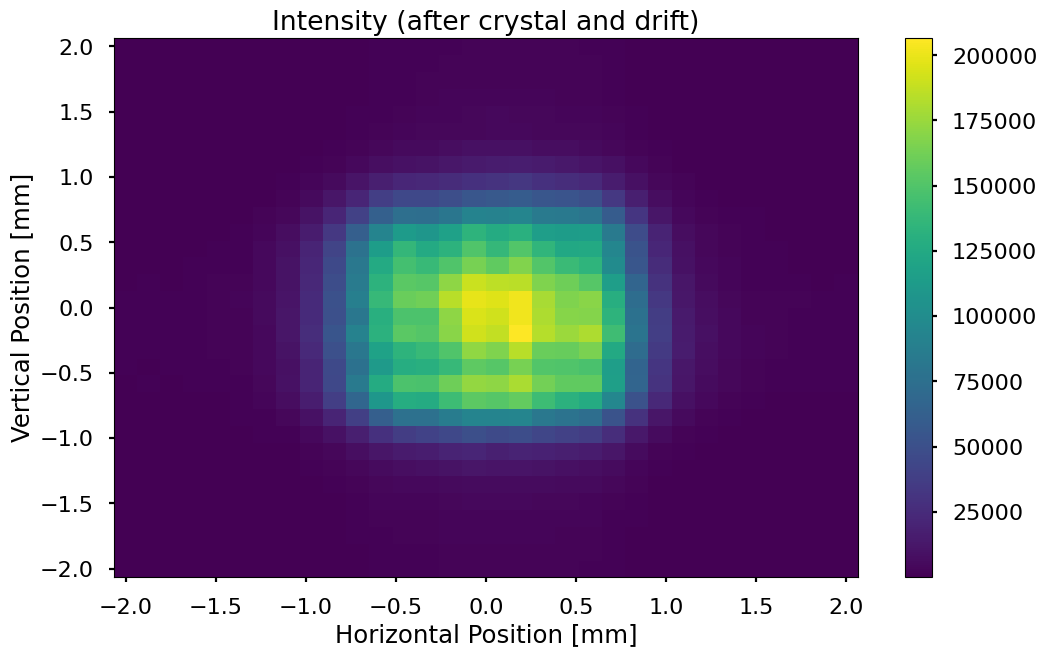

In [22]:
# plot the computed intensity
if RENDER_2D_PLOTS:
    with plt.style.context(('seaborn-poster')):
        fig = plt.figure(figsize=(12,7))
        ax = fig.gca()

        # By setting wfr0a.unitElFldAng=1, default units should  now be in mrad(?)
        plt.pcolormesh(x*1e3, y*1e3, intens2_2d, cmap=plt.cm.viridis,shading='auto')
        plt.colorbar()
        ax.set_ylabel(r'Vertical Position [mm]')
        ax.set_xlabel(r'Horizontal Position [mm]')
        ax.set_title('Intensity (after crystal and drift)')

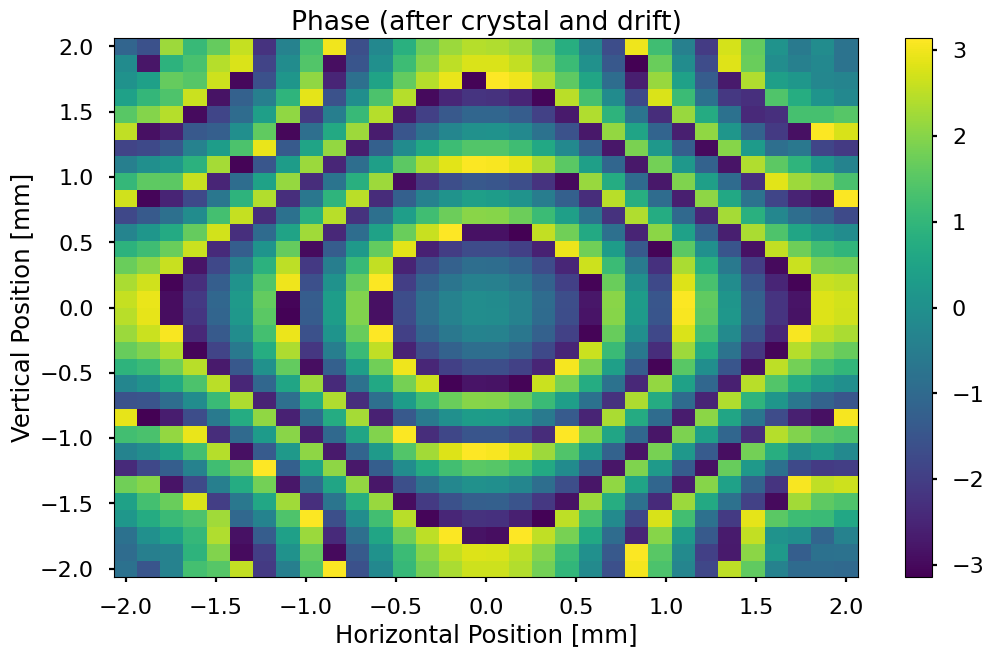

In [23]:
# transmitted pulse - phase
phase2 = srwlib.array('d', [0]*wfr2.mesh.nx*wfr2.mesh.ny) # "flat" array to take 2D intensity data
srwl.CalcIntFromElecField(phase2, wfr2, 0, 4, 3, wfr2.mesh.eStart, 0, 0) #extracts the phase; must use double precision

##Reshaping electric field data from flat to 2D array
phase2_2d = np.array(phase2).reshape((wfr2.mesh.nx, wfr2.mesh.ny), order='C')

# plot the phase
if RENDER_2D_PLOTS:
    with plt.style.context(('seaborn-poster')):
        fig = plt.figure(figsize=(12,7))
        ax = fig.gca()

        # By setting wfr0a.unitElFldAng=1, default units should  now be in mrad(?)
#        plt.pcolormesh(x*1e3, y*1e3, np.unwrap(phase2_2d), cmap=plt.cm.viridis,shading='auto')
        plt.pcolormesh(x*1e3, y*1e3, phase2_2d, cmap=plt.cm.viridis,shading='auto')
        plt.colorbar()
        ax.set_ylabel(r'Vertical Position [mm]')
        ax.set_xlabel(r'Horizontal Position [mm]')
        ax.set_title('Phase (after crystal and drift)')

In [24]:
# calculate the wavefront centroid and rms properties
x_avg, y_avg, x_rms, y_rms = rms_calc_2d(x, y, intens2_2d)

print(' x_avg = {0:4.2e} [m]'.format(x_avg))
print(' y_avg = {0:4.2e} [m]'.format(y_avg))
print(' ')
print(' x_rms = {0:4.2e} [m]'.format(x_rms))
print(' y_rms = {0:4.2e} [m]'.format(y_rms))

 x_avg = 4.53e-05 [m]
 y_avg = -6.34e-05 [m]
 
 x_rms = 5.02e-04 [m]
 y_rms = 5.34e-04 [m]
